## Hyperdrive PnL

In [1]:
from __future__ import annotations

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import logging

import numpy as np
from numpy.random._generator import Generator
from scipy import special
import matplotlib.pyplot as plt

from elfpy import DEFAULT_LOG_MAXBYTES
from elfpy.types import MarketActionType, MarketAction, WEI
from elfpy.simulators import Simulator
from elfpy.agent import Agent
from elfpy.markets import Market
from elfpy.utils.config import Config
from elfpy.utils import sim_utils
import elfpy.utils.outputs as output_utils
import elfpy.utils.parse_config as config_utils
import elfpy.utils.post_processing as post_processing
from elfpy.types import MarketState, StretchedTime
from elfpy.utils.outputs import get_gridspec_subplots

### Setup experiment parameters

In [4]:
log_filename = "../../.logging/hyperdrive_pnl.log" # Output filename for logging
config_file = "../../config/example_config.toml" # Config file to start from (overrides are specified below)

log_level = "WARNING" # Logging level, should be in ["DEBUG", "INFO", "WARNING"]
max_bytes = DEFAULT_LOG_MAXBYTES # Maximum log file output size, in bytes. More than 100 files will cause overwrites.
pricing_model = "Hyperdrive" # can be yieldspace or hyperdrive

num_trading_days = 90 # Number of simulated trading days
token_duration = num_trading_days/365
blocks_per_day = 10#7200 # Blocks in a given day (7200 means ~12 sec per block)
trade_fee_percent = 0.10 # fee percent collected on trades
redemption_fee_percent = 0.005 # 5 bps
target_pool_apr = 0.01 # target pool APR of the initial market after the LP

num_agents = 5 # int specifying how many agents you want to simulate
agent_budget = 1_000_000 # max money an agent can spend
trade_chance = 1 # on a given block, an agent will trade with probability `trade_chance`

target_pool_apr = 0.01 # target pool APR of the initial market after the LP
target_liquidity = 500_000_000 # target total liquidity of the initial market, before any trades

vault_apr_init = 0.01 # Initial vault APR
vault_apr_jump_size = 0.001 # Scale of the vault APR change (vault_apr (+/-)= jump_size)
vault_jumps_per_year = 4#4 # The average number of jumps per year
vault_apr_jump_direction = "random_weighted" # The direction of a rate change. Can be 'up', 'down', or 'random'.
vault_apr_lower_bound = 0.01 # minimum allowable vault apr
vault_apr_upper_bound = 0.01 # maximum allowable vault apr

### Setup random agent

In [5]:
class RandomAgent(Agent):
    """
    Agent that randomly opens or closes longs or shorts
    """

    def __init__(self, rng: Generator, trade_chance: float, wallet_address: int, budget: int = 10_000) -> None:
        """Add custom stuff then call basic policy init"""
        self.trade_chance = trade_chance
        self.rng = rng
        super().__init__(wallet_address, budget)

    def action(self, market: Market) -> list[MarketAction]:
        """Implement a random user strategy

        The agent performs one of four possible trades:
            [OPEN_LONG, OPEN_SHORT, CLOSE_LONG, CLOSE_SHORT]
            with the condition that close actions can only be performed after open actions

        The amount opened and closed is random, within constraints given by agent budget & market reserve levels

        Parameters
        ----------
        market : Market
            the trading market

        Returns
        -------
        action_list : list[MarketAction]
        """
        gonna_trade = self.rng.choice([True, False], p=[self.trade_chance, 1-self.trade_chance])
        if not gonna_trade:
            return []
        # User can always open a trade, and can close a trade if one is open
        available_actions = [MarketActionType.OPEN_SHORT, MarketActionType.OPEN_LONG]
        has_opened_short = bool(any((short.balance > 0 for short in self.wallet.shorts.values())))
        if has_opened_short:
            available_actions.append(MarketActionType.CLOSE_SHORT)
        has_opened_long = bool(any((long.balance > 0 for long in self.wallet.longs.values())))
        if has_opened_long:
            available_actions.append(MarketActionType.CLOSE_LONG)
        action_type = self.rng.choice(available_actions, size=1) # choose one random trade type
        # trade amount is also randomly chosen
        if action_type == MarketActionType.OPEN_SHORT:
            random_normal = self.rng.normal(loc=self.budget * 0.1, scale=self.budget * 0.01)
            max_short = self.get_max_short(market)
            if max_short > WEI: # if max_short is greater than the minimum eth amount
                trade_amount = np.maximum(WEI, np.minimum(max_short, random_normal)) # WEI <= trade_amount <= max_short
                action_list = [
                    self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=market.time),
                ]
            else: # no short is possible
                action_list = []
        elif action_type == MarketActionType.OPEN_LONG:
            random_normal = self.rng.normal(loc=self.budget * 0.1, scale=self.budget * 0.01)
            max_long = self.get_max_long(market)
            if max_long > WEI: # if max_long is greater than the minimum eth amount
                trade_amount = np.maximum(WEI, np.minimum(max_long, random_normal))
                action_list = [
                    self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=market.time),
                ]
            else:
                action_list = []
        elif action_type == MarketActionType.CLOSE_SHORT:
            short_time = self.rng.choice(list(self.wallet.shorts))
            trade_amount = self.wallet.shorts[short_time].balance # close the full trade
            action_list = [
                self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=short_time),
            ]
        elif action_type == MarketActionType.CLOSE_LONG:
            long_time = self.rng.choice(list(self.wallet.longs))
            trade_amount = self.wallet.longs[long_time].balance # close the full trade
            action_list = [
                self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=long_time),
            ]
        else:
            action_list = []
        return action_list


class LPAgent(Agent):
    """
    Adds a large LP
    """
    def action(self, market: Market):
        """
        implement user strategy
        LP if you can, but only do it once
        short if you can, but only do it once
        """
        if self.wallet.lp_tokens > 0: # has already opened the lp
            action_list = []
        else:
            action_list = [
                self.create_agent_action(
                    action_type=MarketActionType.ADD_LIQUIDITY, trade_amount=self.budget
                ),
            ]
        return action_list


def get_example_agents(rng: Generator, budget: float, new_agents: int, existing_agents: int = 0) -> list[Agent]:
    """Instantiate a set of custom agents"""
    agents = []
    for address in range(existing_agents, existing_agents + new_agents):
        agent = RandomAgent(
            rng=rng,
            trade_chance=trade_chance,
            wallet_address=address,
            budget=budget,
        )
        agent.log_status_report()
        agents += [agent]
    return agents

### Define vault apr process

In [6]:
def homogeneous_poisson(
    rng: Generator, rate: float, tmax: int, bin_size: int = 1
    ) -> np.ndarray:
    """Generate samples from a homogeneous Poisson distribution

    Attributes
    ----------
    rng: np.random.Generator
        random number generator with preset seed
    rate: float
        number of events per time interval (units of 1/days)
    tmax: float
        total number of days (units of days; sets distribution support)
    bin_size: float
        resolution of the simulation
    """
    nbins = np.floor(tmax/bin_size).astype(int)
    prob_of_spike = rate * bin_size
    events = (rng.random(nbins) < prob_of_spike).astype(int)
    return events

def event_generator(rng, n_trials, rate, tmax, bin_size):
    """Generate samples from the poisson distribution"""
    for i in range(n_trials):
        yield homogeneous_poisson(rng, rate, tmax, bin_size)

def poisson_prob(k, lam):
    """https://en.wikipedia.org/wiki/Poisson_distribution"""
    return lam**k/special.factorial(k)*np.exp(-lam)

def vault_flip_probs(apr: float, min_apr: float=0.0, max_apr: float=1.0, num: int = 100):
    """
    probability of going up is 1 when apr is min
    probability of going down is 1 when apr is max
    probability is 0.5 either way when apr is half way between max and min
    """
    aprs = np.linspace(min_apr, max_apr, num)
    get_index = lambda value, array : (np.abs(array - value)).argmin()
    apr_index = get_index(apr, aprs) # return whatever value in aprs array that apr is closest to
    up_probs = np.linspace(1, 0, num)
    up_prob = up_probs[apr_index]
    down_prob = 1 - up_prob
    return (down_prob, up_prob)

def poisson_vault_apr(
    config: Config,
    initial_apr: float,
    jump_size: float,
    vault_jumps_per_year: int,
    direction: str,
    lower_bound: float = 0.0,
    upper_bound: float = 1.0,
    num: int = 100
) -> Generator:
    # vault rate changes happen once every vault_jumps_per_year, on average
    num_bins = 365
    bin_size = 1
    rate = vault_jumps_per_year / num_bins
    tmax = num_bins
    do_jump = homogeneous_poisson(config.simulator.rng, rate, tmax, bin_size)
    vault_apr = np.array([initial_apr] * config.simulator.num_trading_days)
    for day in range(1, config.simulator.num_trading_days):
        if not do_jump[day]:
            continue
        if direction == "up":
            sign = 1
        elif direction == "down":
            sign = -1
        elif direction == "random":
            sign = config.simulator.rng.choice([-1, 1], size=1).item() # flip a fair coin
        elif direction == "random_weighted":
            probs = vault_flip_probs(vault_apr[day], lower_bound, upper_bound, num)
            sign = config.simulator.rng.choice([-1, 1], p=probs, size=1).item() # flip a weighted coin
        else:
            raise ValueError(f"Direction must be 'up', 'down', 'weighted_random', or 'random'; not {direction}")
        step = sign * jump_size
        apr = np.minimum(upper_bound, np.maximum(lower_bound, vault_apr[day] + step))
        vault_apr[day:] = apr
    for apr in vault_apr: # janky way to make this a generator
        yield apr

### Setup experiment vault apr using parameters specified above

In [7]:
# override_dict specifies overrides for the config AND the random variables
override_dict = {
    "pricing_model_name": pricing_model,
    "num_trading_days": num_trading_days,
    "num_blocks_per_day": blocks_per_day,
    "pricing_model_name": pricing_model,
    "target_liquidity": target_liquidity,
    "target_pool_apr": target_pool_apr,
    "trade_fee_percent": trade_fee_percent,
    "redemption_fee_percent": redemption_fee_percent,
    "token_duration": token_duration,
    "logging_level": log_level,
}
# override the vault_apr, which is based on some variables set above
override_dict["vault_apr"] = lambda: poisson_vault_apr(
    config=config,
    initial_apr=vault_apr_init,
    jump_size=vault_apr_jump_size,
    vault_jumps_per_year=vault_jumps_per_year,
    direction=vault_apr_jump_direction,
    lower_bound=vault_apr_lower_bound,
    upper_bound=vault_apr_upper_bound,
)
# config variables that match keys in override_dict are overridden
config = config_utils.override_config_variables(config_utils.load_and_parse_config_file(config_file), override_dict)

### Run the simulation

In [8]:
# define root logging parameters
output_utils.setup_logging(
    log_filename=log_filename,
    max_bytes=max_bytes,
    log_level=config_utils.text_to_logging_level(config.simulator.logging_level),
)

# get random agents and draw random simulation parameters
random_agents = get_example_agents(rng=config.simulator.rng, budget=agent_budget, new_agents=num_agents, existing_agents=1)

# random sim variables that match keys in override_dict are overridden
# this includes the target pool apr & target vault apr
random_sim_vars = sim_utils.override_random_variables(sim_utils.get_random_variables(config), override_dict)

# instantiate the pricing model
pricing_model = sim_utils.get_pricing_model(config.amm.pricing_model_name)

In [9]:
# instantiate the market
position_duration = StretchedTime(
    days=config.simulator.token_duration * 365,
    time_stretch=pricing_model.calc_time_stretch(random_sim_vars.target_pool_apr),
)

init_target_liquidity = 1 # tiny amount for setting up apr
share_reserves_direct, bond_reserves_direct = pricing_model.calc_liquidity(
    market_state=MarketState(
        share_price=random_sim_vars.init_share_price,
        init_share_price=random_sim_vars.init_share_price
    ),
    target_liquidity=init_target_liquidity,
    target_apr=random_sim_vars.target_pool_apr,
    position_duration=position_duration,
)
market = Market(
    pricing_model=pricing_model,
    market_state=MarketState(
        share_reserves=share_reserves_direct,
        bond_reserves=bond_reserves_direct,
        base_buffer=0,
        bond_buffer=0,
        lp_reserves=init_target_liquidity / random_sim_vars.init_share_price,
        init_share_price=random_sim_vars.init_share_price,  # u from YieldSpace w/ Yield Baring Vaults
        share_price=random_sim_vars.init_share_price,  # c from YieldSpace w/ Yield Baring Vaults
        vault_apr=random_sim_vars.vault_apr[0],  # yield bearing source apr
        trade_fee_percent=random_sim_vars.trade_fee_percent,  # g
        redemption_fee_percent=random_sim_vars.redemption_fee_percent,
    ),
    position_duration=position_duration
)

In [10]:
# Instantiate the initial LP agent.
current_market_liquidity = market.pricing_model.calc_total_liquidity_from_reserves_and_price(
    market_state=market.market_state, share_price=market.market_state.share_price
)
lp_amount = target_liquidity - current_market_liquidity
init_agents = [LPAgent(wallet_address=0, budget=lp_amount)]

# initialize the simulator using only the initial LP.
simulator = Simulator(
    config=config,
    market=market,
    random_simulation_variables=random_sim_vars,
)
simulator.add_agents(init_agents)
simulator.collect_and_execute_trades()

In [11]:
simulator.agents[0].wallet

Wallet(address=0, base=0.0, lp_tokens=498364643.85455954, longs={}, shorts={}, fees_paid=0)

In [12]:
# add the random agents
random_agents = get_example_agents(rng=simulator.rng, budget=agent_budget, new_agents=num_agents, existing_agents=1)
simulator.add_agents(random_agents)

# run the simulation
simulator.run_simulation()

### Plot simulation results

In [13]:
# convert simulation state to a pandas dataframe
trades = post_processing.compute_derived_variables(simulator)

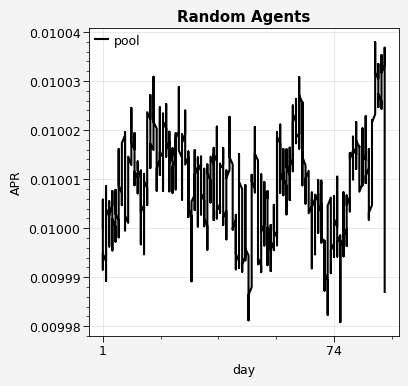

In [14]:
exclude_first_day = False
xtick_step = 73

start_idx = 1 if exclude_first_day else 0
ax = get_gridspec_subplots()[1][0]
#ax = trades.iloc[start_idx:len(trades)-1].plot(x="run_trade_number", y="vault_apr", ax=ax, label="vault", c='blue')
ax = trades.iloc[start_idx:len(trades)-1].plot(x="day", y="pool_apr", ax=ax, label="pool", c='black')
ax.set_title("Random Agents")
ax.set_xlabel("day")
ax.set_ylabel("APR")
#ax.set_ylim([0.0075, 0.0125])
ax.legend()
ax.set_xticks([x for x in range(start_idx, trades["day"].max() + 1, xtick_step)]);
ax.set_xticklabels([str(x+1) for x in range(start_idx, trades["day"].max() + 1, xtick_step)]);

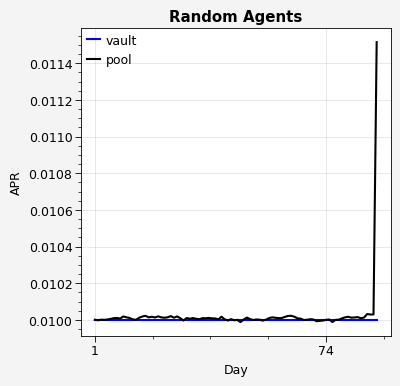

In [15]:
exclude_first_day = False
xtick_step = 73

trades_agg = trades.groupby("day").agg(
    {
        "vault_apr": ["mean"],
        "pool_apr": ["mean"],
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
start_idx = 1 if exclude_first_day else 0
ax = get_gridspec_subplots()[1][0]
ax = trades_agg.iloc[start_idx:].plot(x="day", y="vault_apr_mean", ax=ax, label="vault", c='blue')
ax = trades_agg.iloc[start_idx:].plot(x="day", y="pool_apr_mean", ax=ax, label="pool", c='black')
ax.set_title("Random Agents")
ax.set_xlabel("Day")
ax.set_ylabel("APR")
ax.legend()
ax.set_xticks([x for x in range(start_idx, simulator.config.simulator.num_trading_days + 1, xtick_step)]);
ax.set_xticklabels([str(x+1) for x in range(start_idx, simulator.config.simulator.num_trading_days + 1, xtick_step)]);

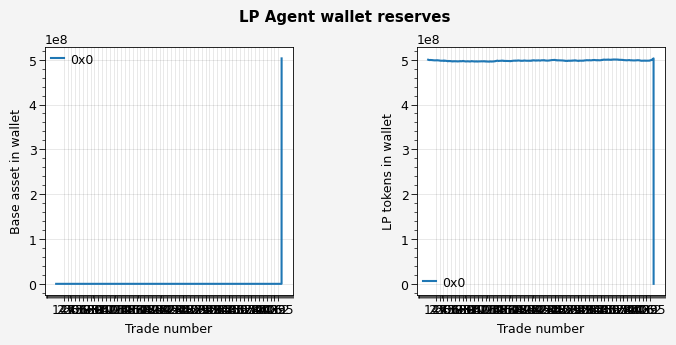

In [16]:
exclude_first_trade = True
exclude_first_agent = False

fig, axes, _ = get_gridspec_subplots(nrows=1, ncols=2, wspace=0.5)
start_idx = 1 if exclude_first_trade else 0
addresses = []
for column in trades.columns:
    splits = column.split("_")
    if splits[0] == "agent":
        addresses.append(int(splits[1]))
agents = set(addresses)
#for address in agents:
address = 0
if (exclude_first_agent and address > 0) or (not exclude_first_agent):
    dict_key = f"agent_{address}"
    _ = trades.iloc[start_idx:].plot(
        x="run_trade_number", y=f"{dict_key}_base", label=f"0x{address}", ax=axes[0]
    )
    _ = trades.iloc[start_idx:].plot(
        x="run_trade_number", y=f"{dict_key}_lp_tokens", label=f"0x{address}", ax=axes[1]
    )
axes[0].set_ylabel("Base asset in wallet")
axes[1].set_ylabel("LP tokens in wallet")
axes[0].legend()
trade_labels = trades.loc[:, "run_trade_number"][::xtick_step][start_idx:]
for axis in axes:
    axis.set_xlabel("Trade number")
    axis.set_xticks(trade_labels[start_idx:])
    axis.set_xticklabels([str(x + 1) for x in trade_labels][start_idx:])
    axis.set_box_aspect(1)
fig_size = fig.get_size_inches()  # [width (or cols), height (or rows)]
fig.set_size_inches([2 * fig_size[0], fig_size[1]])
_ = fig.suptitle("LP Agent wallet reserves", y=0.90)

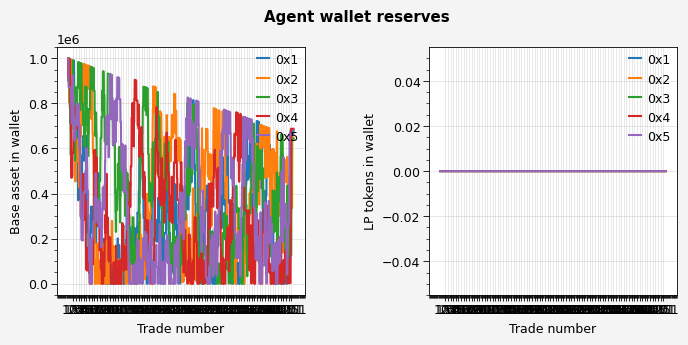

In [17]:
fig = output_utils.plot_wallet_reserves(trades, exclude_first_agent=True, exclude_first_trade=True, xtick_step=50)

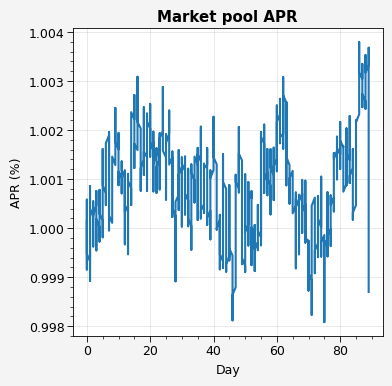

In [18]:
fig = output_utils.plot_pool_apr(trades, exclude_first_day=True, exclude_last_day = True)

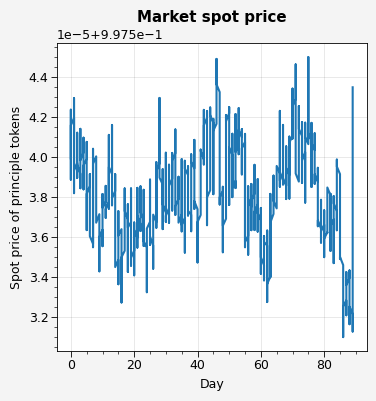

In [19]:
fig = output_utils.plot_market_spot_price(trades, exclude_first_day=True, exclude_last_day = True)

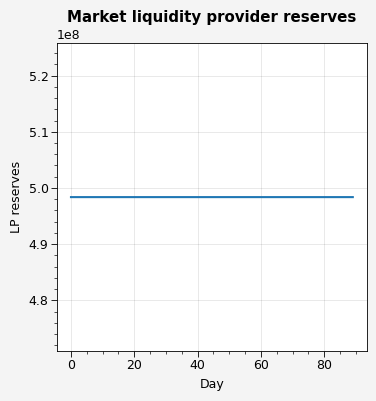

In [20]:
fig = output_utils.plot_market_lp_reserves(trades, exclude_first_day=True, exclude_last_day = True)

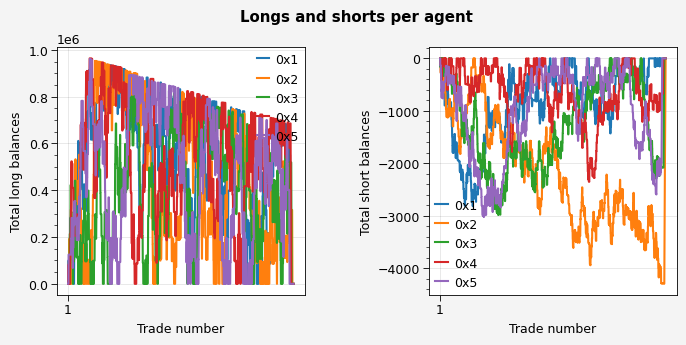

In [21]:
fig = output_utils.plot_longs_and_shorts(trades, exclude_first_trade=True, xtick_step=2000)

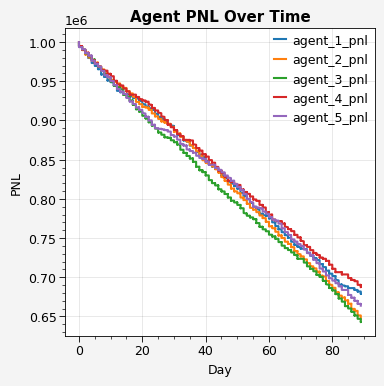

In [22]:
fig = output_utils.plot_agent_pnl(trades, exclude_first_agent=True, exclude_first_day=True)

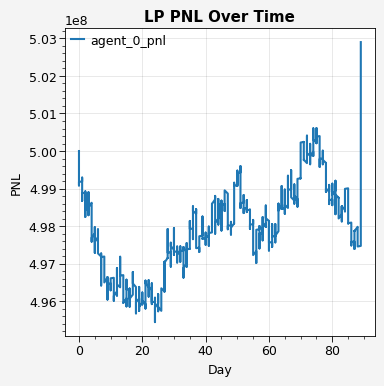

In [23]:
fig = output_utils.plot_lp_pnl(trades, exclude_last_day = True)